<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2018


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> Normalization </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> October 1, 2018</b></p>

<hr style='height:5px;border:none' />

# Brief introduction to Nipype
<hr style="height:1px;border:none" />

## Steps in fMRI data analysis

Although there are different software tools designed for fMRI data analysis, the steps required for such an analysis is very similar for the most part. 

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NeuroImageSchematic.png?raw=true' alt='fMRI processing steps'/>

Different software packages implements these steps to analyze fMRI data. So, in theory, it is possible to mix different steps from different software tools but you can still implement all the necessary steps.

## Why nipype?

Different fMRI analysis software tools have their own scripting capability. In other words, each package lets you write a script (a series of instructions) to implement the entire analysis pipeline from the beginning to the end. This is useful especially you have to run the same pre-processing and analysis steps for multiple subjects. Analyzing multiple subjects' data using a GUI will increase the risk of human error (clicking a wrong button, selecting a wrong file, entering wrong parameters, etc.). 

The syntax to script a processing pipeline is different in different packages. For a starter, in SPM you write a script in MATLAB, whereas in FSL, you need to code in a shell script. **Nipype** enables you to script different steps in different software tools in Python, so that mixing of different steps very easy.

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_WorkflowEg.png?raw=true' alt='Nipype workflow example'/>

Here is an example of how `nipype` implements different steps. The diagram such as this one represents a **workflow**, a series of tasks organized into a diagram, with output from one task fed into the following task. Here, each task is represented as a **node**. A node may take a certain input(s) and produces an output. 

# Preprocessing steps as objects
<hr style="height:1px;border:none" />

Now let's take a look as some simple steps in the data preprocessing as examples of how Nipype works. 

## Skull stripping (FSL)

As you can imagine from the name, skull stripping refers to a process of removing non-brain tissues (skulls, bones, soft tissues) from structural MRI data. This step is necessary for normalization in FSL (to be covered later), but not for SPM. Here is an example code to perform skull stripping in FSL.

`<SkullStrip_fsl.py>`

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# an T1 weighted image from one of the subjects
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w.nii.gz')

I shall use the ds102 data set for this example. In particular, subject 26.

Now, I create an object called **`mybet`**, a skull stripping process object with **`BET`** located under **`nipype.interfaces.fsl`**. 

In [5]:
# creating an object for BET process
mybet = fsl.BET()

Then I specify input and output file names as parameters for the BET object.

In [6]:
# output image file name
imageT1Out = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain.nii.gz')

# specifying the input and output file names in the BET object
mybet.inputs.in_file = imageT1
mybet.inputs.out_file = imageT1Out

Notice that the output file name has the suffix **`_brain`** attached to the input file name. At this point, you are ready to run skull stripping with the **`run()`** method associated with `mybet` object.

In [4]:
# running BET
mybet.run()

Let's see the results from skull stripping. For that, I am calling three functions that I have written, **`show_plane`**, **`show_section`**, and **`load_nii_data`**. They are located under the directory **`functions`**.

In [8]:
# Importing custom functions for displaying sections
import sys
sys.path.append('functions')
from DisplaySection import show_section, load_nii_data

If you are curious, these are the functions that are just imported. 

In [16]:
def show_plane(x):
    '''
    Function to show a slice (provided as a 2D array)
    '''
    plt.imshow(x, cmap="gray")
    plt.gca().set_axis_off()


def show_section(xImg, section, xSlice):
    '''
    Function to return a 2D array of a slice from a 3D array.
    Slice orientation can be specified by the user.
    '''
    if section=='xy':
        tmpImg = xImg[:,:,xSlice]
    elif section=='xz':
        tmpImg = xImg[:,xSlice,:]
    else:
        tmpImg = xImg[xSlice,:,:]
    show_plane(np.rot90(tmpImg))

def load_nii_data(f_nii):
    '''
    Functio to load an NIfTI image and returns the data matrix
    as an array.
    '''
    nii = nib.load(f_nii)
    X = nii.get_data()
    return X

Then displaying the original and skull-stripped images.

In [9]:
%matplotlib inline

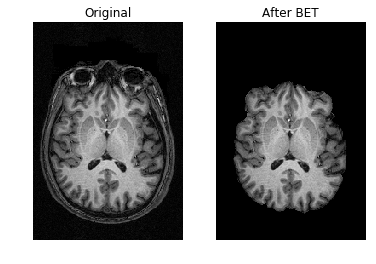

In [10]:
# loading the data matrices
X = load_nii_data(imageT1)
Xbet = load_nii_data(imageT1Out)

# showing the before and after images
plt.subplot(121)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(122)
show_section(Xbet, 'xy', 140)
plt.title('After BET')
plt.show()

One parameter you may possibly manipulate is the *fractional intensity threshold*. This parameter **`mybet.inputs.frac`** alters how laxed / strict about defining brain tissues. The default is 0.5. A smaller value includes a larger volume as the brain, and a larger value includes less volume as the brain. As a comparison, I re-run the skull stripping with `frac`=0.3 and 0.7.  

In [20]:
# playing with thresholds, then the output file
# first, threshold = 0.2
imageT1Out02 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain_f02.nii.gz')
mybet.inputs.frac = 0.2  # here, actually specifying the threshold
mybet.inputs.out_file = imageT1Out02
mybet.run()

# second, threshold = 0.8
imageT1Out08 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain_f08.nii.gz')
mybet.inputs.frac = 0.8  # here, actually specifying the threshold
mybet.inputs.out_file = imageT1Out08
mybet.run()

Let's compare the results.

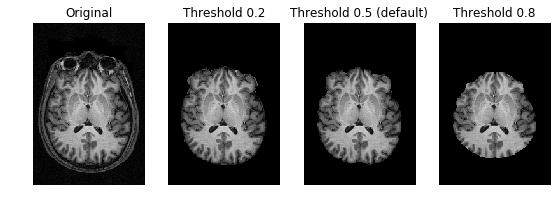

In [31]:
# showing the skull stripping with various parameters
plt.figure(figsize=[8,2.5])
# loading the data matrices
X = load_nii_data(imageT1)
Xbet02 = load_nii_data(imageT1Out02)
Xbet = load_nii_data(imageT1Out)
Xbet08 = load_nii_data(imageT1Out08)

# showing the before and after images
plt.subplot(141)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(142)
show_section(Xbet02, 'xy', 140)
plt.title('Threshold 0.2')
plt.subplot(143)
show_section(Xbet, 'xy', 140)
plt.title('Threshold 0.5 (default)')
plt.subplot(144)
show_section(Xbet08, 'xy', 140)
plt.title('Threshold 0.8')
plt.show()

## Segmentation

Segmentation often refers to the process of separating voxels (from T1-weighted images) into different tissue types: gray matter (GM), white matter (WM), and cerebrospinal fluid (CSF). This is accomplished by the intensity different between the different tissue types, and by modeling the voxel intensity distribution as a mixture of multiple distributions. 

### Segmentation with FSL

FSL requires that you have skull-stripped the T1-wighted image before segmentation. The actual segmentation can be implemented as a **`FAST`** object in **`nipype.interfaces.fsl`**. Here is an example. 

`<Segment_fsl.py>`

In [16]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# an T1 weighted image from one of the subjects, skull stripped
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain.nii.gz')

Notice that the input image is the skull-stripped image I generated earlier.

Then I define **`fslFAST`**, an object for segmentation. 

In [33]:
# creating an object for FAST (segmentation) process
fslFAST = fsl.FAST()

Now, specifying the input and output. Here, the output is not a single image, but a collection of image. So I am providing the **`out_basename`**, the base for the output file names. To this base various suffices are added to denote different output images.

In [17]:
# output base name 
outBase = imageT1.replace('.gz','').replace('.nii','')

In [18]:
outBase

'/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/sub-26/anat/sub-26_T1w_brain'

In [36]:
# specifying the input and output file names in the FAST object
fslFAST.inputs.in_files = imageT1
fslFAST.inputs.out_basename = outBase

Finally, running the segmentation by the **`run()`** method associated with the segmentation object `fslFAST`. ***This process will likely take a few minutes, depending on how fast your computer is.***

In [45]:
# running FAST
fslFAST.run()

TraitError: The trait 'tissue_class_map' of a FASTOutputSpec instance is an existing file name, but the path  '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Notes/sub-26_T1w_brain_seg.nii.gz' does not exist.

You may see an error message here (like I did. Don't know why...). But as long as the output has been generated, I wouldn't worry too much about it.

In [19]:
os.listdir(os.path.split(outBase)[0])

['sub-26_T1w_brain_pve_1.nii.gz',
 'sub-26_T1w_brain_seg.nii.gz',
 'sub-26_T1w_brain_pveseg.nii.gz',
 'sub-26_T1w_brain.nii.gz',
 'sub-26_T1w_brain_mixeltype.nii.gz',
 'sub-26_T1w_brain_pve_2.nii.gz',
 'sub-26_T1w.nii.gz',
 'sub-26_T1w_brain_pve_0.nii.gz']

If you see image files with the suffix containing **`_pve`**, that means that segmentation was successful. Let's examine the results.

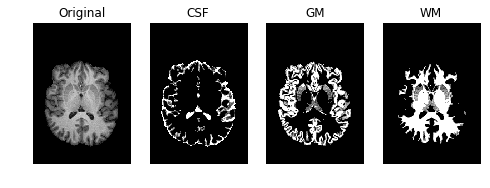

In [20]:

# loading the data matrices
X = load_nii_data(outBase+'.nii.gz')
Xseg0 = load_nii_data(outBase+'_pve_0.nii.gz')
Xseg1 = load_nii_data(outBase+'_pve_1.nii.gz')
Xseg2 = load_nii_data(outBase+'_pve_2.nii.gz')

# showing the before and after images
plt.figure(figsize=[8,3])
plt.subplot(141)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(142)
show_section(Xseg0, 'xy', 140)
plt.title('CSF')
plt.subplot(143)
show_section(Xseg1, 'xy', 140)
plt.title('GM')
plt.subplot(144)
show_section(Xseg2, 'xy', 140)
plt.title('WM')
plt.show()

In FSL,
  * Suffix: `_pve_0` -- CSF
  * Suffix: `_pve_1` -- Gray matter
  * Suffix: `_pve_2` -- White matter


### Segmentation with SPM

SPM has its own segmentation process. It does not require the user to skull-strip the T1 weighted image. Here is the example code for segmentation with SPM.

`<Segment_spm.py>`

In [21]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype.algorithms.misc import Gunzip  # gunzip interface


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'

In [22]:
# an T1 weighted image from one of the subjects
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w.nii.gz')

Here, the input NIfTI file is compressed (with **`.nii.gz`**). However, SPM cannot handle compressed NIfTI files, so I need to uncompress the image data with an **`Gunzip`** object defined under **`nipype.algorithms.misc`**.

In [23]:
# gunzip object
gunzip = Gunzip()

# unzipping the T1 image first
gunzip.inputs.in_file = imageT1
res = gunzip.run()

The uncompressed file is written to the current working directory. The path can be accessed by **`res.outputs.out_file`**.

In [24]:
res.outputs.out_file

'/home/satoru/Teaching/fMRI_Fall_2018/Notes/sub-26_T1w.nii'

Now let's create a segmentation object called **`spmSeg`**, as a **`NewSegment`** object in **`nipype.interfaces.spm`**. 

In [25]:
# creating an object for segmentation process
spmSeg = spm.NewSegment()

# specifying the input file in the segmentation object
spmSeg.inputs.channel_files = res.outputs.out_file

The input is the uncompressed file from earlier. Now we are ready to run the segmentation process with the **`run()`** method.

In [26]:
# running segmentation
spmSeg.run()

Like FSL's segmentation, SPM's segmentation generates a large number of files.

In [28]:
listFiles = os.listdir(os.getcwd())
listNii = [i for i in listFiles if 'nii' in i]
listNii

['c1sub-26_T1w.nii',
 'sub-26_T1w.nii',
 'c4sub-26_T1w.nii',
 'c2sub-26_T1w.nii',
 'c3sub-26_T1w.nii',
 'c5sub-26_T1w.nii']

# Normalization - Theory
<hr style="height:1px;border:none" />

## What is normalization?

As you can imagine, everybody's head has a different shape, thus everybody's brain is different. Consequently, comparing brains from multiple people can be challenging. One solution is to *warp* everybody's brain into the standard shape brain (often referred as the **template**) so that we can compare brains across subjects.

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_Concept.png?raw=true' alt='Idea of normalization'/>

Normalization is typically performed using a subject's structural MRI data. The warp from the subject's **native space** to the **template space** is often estimated.  

### Native and template spaces

What is a **native space**? This refers to the subject's original brain space ***before*** warping. Since voxel coordinates for particular anatomical landmarks are specific to each subject, native space coordinates are rarely reported. 

<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_NativeSpace.png?raw=true' alt='Native space'/>

What is the **template space**? This refers to, as you can imagine from the name, the space of the template image. Voxel coordinates from the template space are often reported in the literature since it is in the standard space. 

<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_TemplateSpace.png?raw=true' alt='Template space'/>

In the early days of brain imaging research (in the 90s and early 2000), people used the Talairach atlas (by Talairach & Tournoux, 1988) as the template. The Talairach atlas is defined based on a single post-mortem brain. Today, the MNI (Montreal Neurological Institute) template is most widely used. The MNI template is the average of 152 high resolution brain images (of young adults) warped with high-dimensional transformation to a common space. 

## How are images normalized

In many software packages, normalization is performed in two steps; a **linear** registration followed by a **non-linear** registration

### Linear registration

The goal of linear registration is to roughly match a subject's brain with the template brain. A linear registration consists of 4 different types of mathematical operations (translation, rotation, scaling, and shear) in 3 different directions (x-, y-, and z-directions). These transformations are often referred as the **affine transformation**. In total, there are 12 possible operations in an affine transformation, it can be described in a 3x4 matrix, known as an *affine matrix*.

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_Linear.png?raw=true' alt='Linear registration'/>


A linear registration is applied to the entire image, without any local refinement.

### Non-linear registration

The goal of non-linear registration is to warp an image locally to match the template as much as possible. Since non-linear registration is performed locally, a very large number of parameters are needed to describe such a transformation. A sophisticate non-linear registration algorithm requires significant computational resources (like, a super-computer) and hours of calculation. Algorithms used by fMRI analysis packages are much less sophisticated, and can be run on a decent work station in 30 min or less. However, even such simple algorithms require thousands of parameters.

<img style='width: 450px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_NonLinear.png?raw=true' alt='Non-linear registration'/>


* Bias field
* Cost function
* Regularization

# Normalization with Nipype
<hr style="height:1px;border:none" />

* With FSL
* With SPM
* With ANTs
* Quality control
   * Overlay
   * Average
   * Movie
* Exercise
   * Different levels of regularization
   

# Normalization with a template
<hr style="height:1px;border:none" />

* Pediatric template
* Exercise
    * Difference between regular template vs pediatric template